In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import interpolate
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
import string
import datetime
from geopack import geopack

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xarray as xr


sys.path.append('/home/sachin/miniconda3/envs/torch_env/') #sever
from esn_dts_openloop import ESN, Tikhonov

Load IGRF coefficients ...


In [2]:
def open_omni():
    df = pd.read_csv('/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro_5min_1999-10.csv')
    #df = pd.read_csv('/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro2_5min_2004_2007.csv')
    
    df = df[df['BY_GSE'] < 100]
    df = df[df['BZ_GSE'] < 100]
    df = df[df['flow_speed'] < 1400]
    df = df[df['proton_density'] < 150]
    df = df[df['F10.7'] < 400]
    df = df[df['Kp'] < 100]
    df['Kp'] = df['Kp'] / 10
    df[['F10.7','flow_speed']] = df[['F10.7','flow_speed']].astype(int)
    
    df['Timestamp_1min_omni'] = pd.to_datetime(df['Timestamp_1min_omni'])
    
    #df = df[df['Timestamp_1min_omni'] == '1999-10-22 05:50:00']
    df = df[df['Timestamp_1min_omni'].between('1999-10-22 02:30:00', '1999-10-22 08:00:00')]
    #df = df[df['Timestamp_1min_omni'].between('2004-01-01 00:00:00', '2004-12-31 23:59:59')]
    #df = df[df['Timestamp_1min_omni'].between('1999-10-21 21:00:00', '1999-10-23 00:00:00')]

    #Weimer comparison
    #df = df[df['Timestamp_1min_omni'].between('1995-10-18 15:00:00', '1995-10-19 00:00:00')]
    
    df = df.set_index('Timestamp_1min_omni')
    #df = df.resample('1h').mean(numeric_only=True)
    df = df.reset_index()

    return df

omni_data = open_omni()
omni_data

,Timestamp_1min_omni,BY_GSE,BZ_GSE,flow_speed,proton_density,AE_INDEX,AL_INDEX,AU_INDEX,Timestamp_1hr_omni,F10.7,Kp,tilt_angle
0,1999-10-22 02:30:00,-11.61,-9.230000,474,7.360000,457,-368,89,1999-10-22 02:00:00,158,7.0,-0.346152
1,1999-10-22 02:35:00,-10.31,-11.260000,482,8.940000,458,-364,94,1999-10-22 02:00:00,158,7.0,-0.348217
2,1999-10-22 02:40:00,-6.51,-16.309999,481,8.360000,402,-320,82,1999-10-22 02:00:00,158,7.0,-0.350205
3,1999-10-22 02:45:00,-4.79,-18.600000,469,10.660000,418,-368,50,1999-10-22 02:00:00,158,7.0,-0.352114
4,1999-10-22 02:50:00,-10.07,-13.220000,493,6.480000,382,-293,90,1999-10-22 02:00:00,158,7.0,-0.353943
...,...,...,...,...,...,...,...,...,...,...,...,...
62,1999-10-22 07:40:00,10.16,4.930000,612,35.279999,360,-291,69,1999-10-22 07:00:00,158,8.0,-0.312427
63,1999-10-22 07:45:00,8.45,4.710000,618,34.349998,506,-441,65,1999-10-22 07:00:00,158,8.0,-0.309415
64,1999-10-22 07:50:00,4.99,2.350000,627,29.870001,470,-361,109,1999-10-22 07:00:00,158,8.0,-0.306346
65,1999-10-22 07:55:00,0.58,-1.860000,639,25.809999,425,-311,114,1999-10-22 07:00:00,158,8.0,-0.303224


In [3]:
def split_to_df(df):

    df = df.copy()

    def calculate_tilt_angle(row):
        t0 = datetime.datetime(1970, 1, 1)
        t1 = row['Timestamp_1min_omni']
        tdiff = (t1 - t0).total_seconds()
        tilt_angle = geopack.recalc(tdiff) # Calculate dipole tilt angle
        
        return tilt_angle
    
    df['tilt_angle'] = df.apply(calculate_tilt_angle, axis=1)

    #create grid of lat and lon
    lat = np.linspace(50, 90, 30) #30 intervals between 53.1° to 89.7°
    lon = np.linspace(0, 360, 80) #80 intervals between 1.6° to 357.6°

    #lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
    #lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

    lat_mesh, lon_mesh = np.meshgrid(lat, lon)
    lats = lat_mesh.flatten()
    lons = lon_mesh.flatten()

    #expand out df to lat and lon dims. Aka repeat values 
    expanded_df = pd.DataFrame({'lat': lats.repeat(len(df)), 
                                'lon': lons.repeat(len(df)),
                                'BY_GSE': np.tile(df['BY_GSE'], len(lat)*len(lon)),
                                'BZ_GSE': np.tile(df['BZ_GSE'], len(lat)*len(lon)),
                                'flow_speed': np.tile(df['flow_speed'], len(lat)*len(lon)),
                                'proton_density': np.tile(df['proton_density'], len(lat)*len(lon)),
                                'tilt_angle': np.tile(df['tilt_angle'], len(lat)*len(lon)),
                                'dt': np.tile(df['Timestamp_1min_omni'], len(lat)*len(lon)),
                                'F10.7': np.tile(df['F10.7'], len(lat)*len(lon)),
                                'Kp': np.tile(df['Kp'], len(lat)*len(lon)),
                                'AE_INDEX': np.tile(df['AE_INDEX'], len(lat)*len(lon)),
                                'AL_INDEX': np.tile(df['AL_INDEX'], len(lat)*len(lon)),
                                'AU_INDEX': np.tile(df['AU_INDEX'], len(lat)*len(lon))
                                })

    expanded_df['mlt'] = np.mod(expanded_df['lon'] + 12, 360) / 15


    df_esn = expanded_df.copy()
    df_esn = df_esn[['dt','lat','lon','BY_GSE','BZ_GSE','flow_speed','proton_density','tilt_angle']]
    
    return df_esn

df_esn = split_to_df(omni_data)
df_esn

,dt,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle
0,1999-10-22 02:30:00,50.0,0.0,-11.61,-9.230000,474,7.360000,-0.346152
1,1999-10-22 02:35:00,50.0,0.0,-10.31,-11.260000,482,8.940000,-0.348217
2,1999-10-22 02:40:00,50.0,0.0,-6.51,-16.309999,481,8.360000,-0.350205
3,1999-10-22 02:45:00,50.0,0.0,-4.79,-18.600000,469,10.660000,-0.352114
4,1999-10-22 02:50:00,50.0,0.0,-10.07,-13.220000,493,6.480000,-0.353943
...,...,...,...,...,...,...,...,...
160795,1999-10-22 07:40:00,90.0,360.0,10.16,4.930000,612,35.279999,-0.312427
160796,1999-10-22 07:45:00,90.0,360.0,8.45,4.710000,618,34.349998,-0.309415
160797,1999-10-22 07:50:00,90.0,360.0,4.99,2.350000,627,29.870001,-0.306346
160798,1999-10-22 07:55:00,90.0,360.0,0.58,-1.860000,639,25.809999,-0.303224


In [4]:
def load_esn(df):

    df = df.copy()
    df['dt'] = pd.to_datetime(df['dt'])
    df = df.set_index(['dt','lat','lon'])
    ds = df.to_xarray()
    
    ds['BY_GSE'] = ds['BY_GSE'].mean(dim=['lat', 'lon'])
    ds['BZ_GSE'] = ds['BZ_GSE'].mean(dim=['lat', 'lon'])
    ds['flow_speed'] = ds['flow_speed'].mean(dim=['lat', 'lon'])
    ds['proton_density'] = ds['proton_density'].mean(dim=['lat', 'lon'])
    ds['tilt_angle'] = ds['tilt_angle'].mean(dim=['lat', 'lon'])

    def load_model_pca(parameter, id):
        
        with open(f'/home/sachin/Documents/NIPR/Research/Data/ESN/models/SMRAI2_{parameter}_ID{id}.pkl', 'rb') as f:
            model = pickle.load(f)

        
        pca_reload = pickle.load(open(f'/home/sachin/Documents/NIPR/Research/Data/ESN/models/ESN_{parameter}_pca_ID{id}.pkl','rb'))

        return model, pca_reload
    
    pot_model, pot_pca = load_model_pca('potential', 25)
    x_model, x_pca = load_model_pca('x-cond', 5)
    y_model, y_pca = load_model_pca('y-cond', 5)
    xy_model, xy_pca = load_model_pca('xy-cond', 5)
   # fac_model, fac_pca = load_model_pca('fac', 5)

    def make_predictions(ds, model, pca):
        ds = ds.copy()
        prediction_arr = ds.to_array().values.T
        prediction = model.predict(prediction_arr)

        prediction_original = pca.inverse_transform(prediction)
        prediction_original = prediction_original.reshape(-1, 30,80)

        return prediction_original

    prediction_potential = make_predictions(ds, pot_model, pot_pca)
    prediction_x = make_predictions(ds, x_model, x_pca)
    prediction_y = make_predictions(ds, y_model, y_pca)
    prediction_xy = make_predictions(ds, xy_model, xy_pca)
    #prediction_fac = make_predictions(ds, fac_model, fac_pca)

    ds['esn_pot'] = (('dt','lat','lon'), prediction_potential)
    ds['esn_x'] = (('dt','lat','lon'), prediction_x)
    ds['esn_y'] = (('dt','lat','lon'), prediction_y)
    ds['esn_xy'] = (('dt','lat','lon'), prediction_xy)
    #ds['esn_fac'] = (('dt','lat','lon'), prediction_fac)

    #df = ds.to_dataframe()
    #df = df.reset_index()
    #df = df[df['lat'].between(60, 70)]

    return ds

df_esn = load_esn(df_esn)
df_esn

<xarray.Dataset> Size: 5MB
Dimensions:         (dt: 67, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 536B 1999-10-22T02:30:00 ... 1999-10-...
  * lat             (lat) float64 240B 50.0 51.38 52.76 ... 87.24 88.62 90.0
  * lon             (lon) float64 640B 0.0 4.557 9.114 ... 350.9 355.4 360.0
Data variables:
    BY_GSE          (dt) float64 536B -11.61 -10.31 -6.51 ... 4.99 0.58 0.86
    BZ_GSE          (dt) float64 536B -9.23 -11.26 -16.31 ... 2.35 -1.86 -5.16
    flow_speed      (dt) float64 536B 474.0 482.0 481.0 ... 627.0 639.0 634.0
    proton_density  (dt) float64 536B 7.36 8.94 8.36 10.66 ... 29.87 25.81 24.67
    tilt_angle      (dt) float64 536B -0.3462 -0.3482 -0.3502 ... -0.3032 -0.3
    esn_pot         (dt, lat, lon) float64 1MB 2.208 1.371 ... -5.847 -5.869
    esn_x           (dt, lat, lon) float64 1MB 1.844 1.844 1.844 ... 1.268 1.268
    esn_y           (dt, lat, lon) float64 1MB 1.624 1.624 1.624 ... 1.265 1.265
    esn_xy          (dt, lat, lon) float64 1MB 1.516 1.516 1.516 ... 1.966 1.966

In [5]:
def calculate_E(ds):
    ds = ds.copy()

    def calculate_distance(lat1, lon1, lat2, lon2):
        
        radius = 6371.008 * 1000 #km to m

        dlat = np.radians(lat2 - lat1)
        dlon = np.radians(lon2 - lon1)
        delta_x = dlat * radius #111.32 km per degree
        delta_y = dlon * radius * np.cos(np.radians(lat1)) 

        #area = delta_x * delta_y
        area = radius**2 * (np.sin(np.radians(lat2)) - np.sin(np.radians(lat1))) * (np.radians(lon2) - np.radians(lon1))
        #avg_lat = np.radians(lat1 + lat2) / 2
        #area = radius**2 *  dlat * dlon * np.cos(avg_lat)
        
        return delta_x, delta_y, area

    def calculate_delta(mlat, mlt):
        #loop through lat and lon and calculate distance between each point
        areas = np.zeros((len(mlat) - 1, len(mlt) - 1))
        delta_x = np.zeros((len(mlat) - 1, len(mlt) - 1))
        delta_y = np.zeros((len(mlat) - 1, len(mlt) - 1))
        for i in range(len(mlat) - 1):
            for j in range(len(mlt) - 1):
                lat1, lat2 = mlat[i], mlat[i + 1]
                lon1, lon2 = mlt[j], mlt[j + 1]

                dx, dy, area = calculate_distance(lat1, lon1, lat2, lon2)
                #area = dx * dy
                delta_x[i, j] = dx
                delta_y[i, j] = dy
                areas[i, j] = area

        x = np.arange(areas.shape[1])
        y = np.arange(areas.shape[0])
        f = interpolate.interp2d(x, y, areas, kind='linear')
        xnew = np.arange(0, areas.shape[1], areas.shape[1]/(areas.shape[1]+1))
        ynew = np.arange(0, areas.shape[0], areas.shape[0]/(areas.shape[0]+1))
        areas = f(xnew, ynew)

        return delta_x, delta_y, areas
    
    #loop through each timestep and calculate the gradient based on potential, with spacings of dx and dy
    data_array = []
    for dt in ds['dt'].values:
        ds_dt = ds.sel(dt=dt)

        lat = ds_dt['lat'].values
        lon = ds_dt['lon'].values

        delta_x, delta_y, areas = calculate_delta(lat, lon)
        #delta_x, delta_y = delta_x * 1000, delta_y * 1000 #km to m
        #delta_y = np.flipud(delta_y)
        
        potential = ds_dt['esn_pot'].values * 1000  #kV to V

        #add 0 to end of delta_x dim 0
        delta_x = np.append(delta_x, np.ones((1, delta_x.shape[1])), axis=0)
        delta_y = np.append(delta_y, np.ones((delta_y.shape[0], 1)), axis=1)
        #area = delta_x * delta_y

        grad_x = np.zeros((potential.shape[0], potential.shape[1] - 1), dtype=np.float64)
        grad_y = np.zeros((potential.shape[0] - 1, potential.shape[1]), dtype=np.float64)

        # Calculate lon with dynamic spacing
        for i in range(potential.shape[0]):
            grad_x[i, :] = (potential[i, 1:] - potential[i, :-1]) / delta_x[i, :]

        # Calculate lat with dynamic spacing
        for j in range(potential.shape[1]):
            grad_y[:, j] = (potential[1:, j] - potential[:-1, j]) / delta_y[:, j]

        # Initialize full gradients to match the original array shape
        grad_x_full = np.zeros_like(potential, dtype=np.float64)
        grad_y_full = np.zeros_like(potential, dtype=np.float64)

        # Fill in the gradients with the calculated values
        grad_x_full[:, :-1] = grad_x
        grad_x_full[:, -1] = (potential[:, -1] - potential[:, -2]) / delta_x[:, -1]  # Simple forward difference

        grad_y_full[:-1, :] = grad_y
        grad_y_full[-1, :] = (potential[-1, :] - potential[-2, :]) / delta_y[-1, :]  #
        
        Ex = -grad_x_full
        Ey = -grad_y_full

        ds_dt['Ex'] = (('lat','lon'), Ex)  
        ds_dt['Ey'] = (('lat','lon'), Ey)
        ds_dt['area'] = (('lat','lon'), areas)

        data_array.append(ds_dt)

    ds = xr.concat(data_array, dim='dt')
    ds = ds.sel(lat=slice(50, 89), lon=slice(0, 357))

    return ds

ds_E = calculate_E(df_esn)
ds_E

/tmp/ipykernel_23214/4127787796.py:38: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(x, y, areas, kind='linear')
/tmp/ipykernel_23214/4127787796.py:41: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator

<xarray.Dataset> Size: 9MB
Dimensions:         (dt: 67, lat: 29, lon: 79)
Coordinates:
  * dt              (dt) datetime64[ns] 536B 1999-10-22T02:30:00 ... 1999-10-...
  * lat             (lat) float64 232B 50.0 51.38 52.76 ... 85.86 87.24 88.62
  * lon             (lon) float64 632B 0.0 4.557 9.114 ... 346.3 350.9 355.4
Data variables:
    BY_GSE          (dt) float64 536B -11.61 -10.31 -6.51 ... 4.99 0.58 0.86
    BZ_GSE          (dt) float64 536B -9.23 -11.26 -16.31 ... 2.35 -1.86 -5.16
    flow_speed      (dt) float64 536B 474.0 482.0 481.0 ... 627.0 639.0 634.0
    proton_density  (dt) float64 536B 7.36 8.94 8.36 10.66 ... 29.87 25.81 24.67
    tilt_angle      (dt) float64 536B -0.3462 -0.3482 -0.3502 ... -0.3032 -0.3
    esn_pot         (dt, lat, lon) float64 1MB 2.208 1.371 ... -6.104 -6.229
    esn_x           (dt, lat, lon) float64 1MB 1.844 1.844 1.844 ... 1.366 1.365
    esn_y           (dt, lat, lon) float64 1MB 1.624 1.624 1.624 ... 1.363 1.363
    esn_xy          (dt, lat, lon) float64 1MB 1.516 1.516 1.516 ... 2.34 2.338
    Ex              (dt, lat, lon) float64 1MB 0.005461 0.005543 ... 0.000799
    Ey              (dt, lat, lon) float64 1MB 0.0003104 0.0004796 ... -0.03138
    area            (dt, lat, lon) float64 1MB 4.923e+10 4.923e+10 ... 2.681e+09

In [6]:
ds_E['Jhx'] = (-ds_E['esn_xy'] * ds_E['Ex']) * 1000 #magnetic north
ds_E['Jhy'] = (ds_E['esn_xy'] * ds_E['Ey']) *  1000 #magnetic east
#ds_E['Jh'] = ds_E['Jhx'] + ds_E['Jhy']

In [7]:
#interpolate ds_E over 1 daily
#ds_E = ds_E.resample(dt='1D').mean()
df_E = ds_E.to_dataframe()
df_E = df_E.reset_index()
df_E

,dt,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,esn_pot,esn_x,esn_y,esn_xy,Ex,Ey,area,Jhx,Jhy
0,1999-10-22 02:30:00,50.00000,0.000000,-11.61,-9.23,474.0,7.36,-0.346152,2.208452,1.844320,1.624134,1.516323,0.005461,0.000310,4.923327e+10,-8.280947,0.470653
1,1999-10-22 02:30:00,50.00000,4.556962,-11.61,-9.23,474.0,7.36,-0.346152,1.370853,1.844320,1.624139,1.516318,0.005543,0.000480,4.923327e+10,-8.404815,0.727232
2,1999-10-22 02:30:00,50.00000,9.113924,-11.61,-9.23,474.0,7.36,-0.346152,0.520723,1.844320,1.624138,1.516316,0.005612,0.000646,4.923327e+10,-8.509701,0.978812
3,1999-10-22 02:30:00,50.00000,13.670886,-11.61,-9.23,474.0,7.36,-0.346152,-0.340017,1.844319,1.624139,1.516316,0.005661,0.000810,4.923327e+10,-8.584292,1.227504
4,1999-10-22 02:30:00,50.00000,18.227848,-11.61,-9.23,474.0,7.36,-0.346152,-1.208302,1.844319,1.624139,1.516316,0.005685,0.000971,4.923327e+10,-8.620451,1.472369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153492,1999-10-22 08:00:00,88.62069,337.215190,0.86,-5.16,634.0,24.67,-0.300048,-5.710452,1.367325,1.364564,2.339196,0.000868,0.002953,2.680971e+09,-2.029326,6.908342
153493,1999-10-22 08:00:00,88.62069,341.772152,0.86,-5.16,634.0,24.67,-0.300048,-5.843507,1.366992,1.364260,2.340497,0.000858,-0.005828,2.680971e+09,-2.008628,-13.640260
153494,1999-10-22 08:00:00,88.62069,346.329114,0.86,-5.16,634.0,24.67,-0.300048,-5.975132,1.366562,1.363825,2.340782,0.000841,-0.014534,2.680971e+09,-1.969546,-34.021952
153495,1999-10-22 08:00:00,88.62069,350.886076,0.86,-5.16,634.0,24.67,-0.300048,-6.104181,1.366011,1.363278,2.340016,0.000815,-0.023085,2.680971e+09,-1.907915,-54.019448


In [8]:
df_JHy_esn_max = df_E.groupby('dt')['Jhx'].max().reset_index()
df_JHy_esn_max.columns = ['dt','AU']

df_JHy_esn_min = df_E.groupby('dt')['Jhx'].min().reset_index()
df_JHy_esn_min.columns = ['dt','AL']

df_ae = pd.merge(df_JHy_esn_max, df_JHy_esn_min, on='dt')

df_ae['AE'] = df_ae['AU'] - df_ae['AL']
df_ae = df_ae[df_ae['AE'] < 4000]

omni_data['dt'] = pd.to_datetime(omni_data['Timestamp_1min_omni'])
merge_df = pd.merge(df_ae, omni_data, on='dt')
merge_df.head()

,dt,AU,AL,AE,Timestamp_1min_omni,BY_GSE,BZ_GSE,flow_speed,proton_density,AE_INDEX,AL_INDEX,AU_INDEX,Timestamp_1hr_omni,F10.7,Kp,tilt_angle
0,1999-10-22 02:30:00,102.482056,-176.818543,279.300600,1999-10-22 02:30:00,-11.61,-9.230000,474,7.36,457,-368,89,1999-10-22 02:00:00,158,7.0,-0.346152
1,1999-10-22 02:35:00,122.540674,-213.417813,335.958487,1999-10-22 02:35:00,-10.31,-11.260000,482,8.94,458,-364,94,1999-10-22 02:00:00,158,7.0,-0.348217
2,1999-10-22 02:40:00,182.084193,-327.724022,509.808215,1999-10-22 02:40:00,-6.51,-16.309999,481,8.36,402,-320,82,1999-10-22 02:00:00,158,7.0,-0.350205
3,1999-10-22 02:45:00,229.358997,-404.123755,633.482752,1999-10-22 02:45:00,-4.79,-18.600000,469,10.66,418,-368,50,1999-10-22 02:00:00,158,7.0,-0.352114
4,1999-10-22 02:50:00,143.670460,-264.472682,408.143143,1999-10-22 02:50:00,-10.07,-13.220000,493,6.48,382,-293,90,1999-10-22 02:00:00,158,7.0,-0.353943


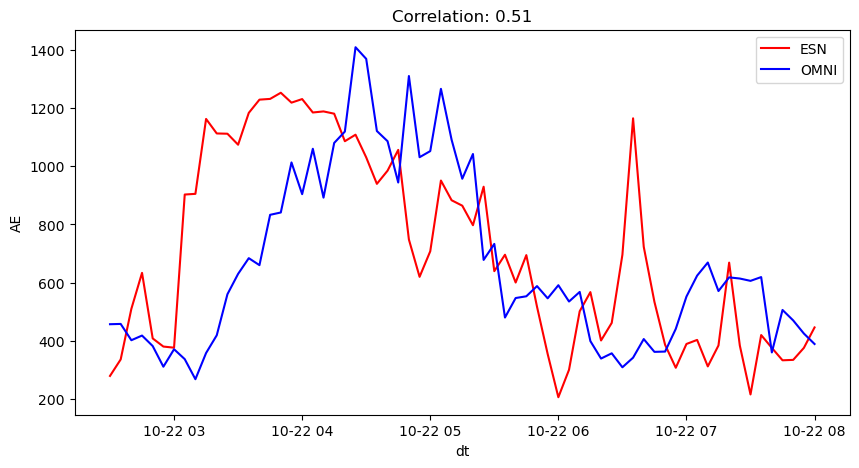

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
R = np.corrcoef(merge_df['AE'], merge_df['AE_INDEX'])[0,1]
plt.title(f'Correlation: {R:.2f}')
sns.lineplot(data=merge_df, x='dt', y='AE', color='red', label='ESN', ax=ax, legend=False)
sns.lineplot(data=merge_df, x='Timestamp_1min_omni', y='AE_INDEX', color='blue', label='OMNI', ax=ax)
plt.legend()

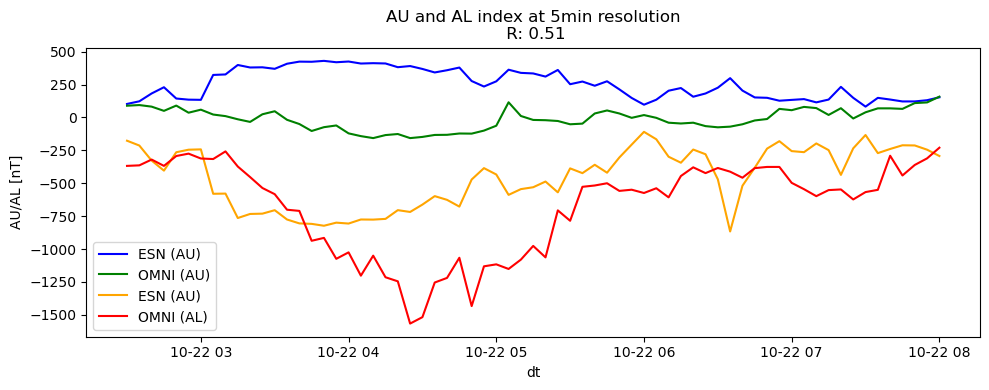

In [10]:
fig, ax = plt.subplots(figsize=(10,4))
R = np.corrcoef(merge_df['AE'], merge_df['AE_INDEX'])[0,1]
sns.lineplot(data=merge_df, x='dt', y='AU', color='blue', label='ESN (AU)', legend=False)
sns.lineplot(data=merge_df, x='Timestamp_1min_omni', y='AU_INDEX', color='green', label='OMNI (AU)')
sns.lineplot(data=merge_df, x='dt', y='AL', color='orange', label='ESN (AU)', legend=False)
sns.lineplot(data=merge_df, x='Timestamp_1min_omni', y='AL_INDEX', color='red', label='OMNI (AL)')
plt.ylabel('AU/AL [nT]')
plt.title(f'AU and AL index at 5min resolution\n R: {R:.2f}')
plt.tight_layout()
#plt.savefig('ESN_AU-AL_5min.png', dpi=300)

In [11]:
#ds_E['JPx'] = ds_E['esn_x'] * ds_E['Ex']
#ss_E['JPy'] = ds_E['esn_y'] * ds_E['Ey']
ds_E['Qjx'] = ((ds_E['esn_x']) * (ds_E['Ex'])**2) *1e3
ds_E['Qjy'] = ((ds_E['esn_y']) * (ds_E['Ey'])**2) *1e3
ds_E

<xarray.Dataset> Size: 14MB
Dimensions:         (dt: 67, lat: 29, lon: 79)
Coordinates:
  * dt              (dt) datetime64[ns] 536B 1999-10-22T02:30:00 ... 1999-10-...
  * lat             (lat) float64 232B 50.0 51.38 52.76 ... 85.86 87.24 88.62
  * lon             (lon) float64 632B 0.0 4.557 9.114 ... 346.3 350.9 355.4
Data variables: (12/16)
    BY_GSE          (dt) float64 536B -11.61 -10.31 -6.51 ... 4.99 0.58 0.86
    BZ_GSE          (dt) float64 536B -9.23 -11.26 -16.31 ... 2.35 -1.86 -5.16
    flow_speed      (dt) float64 536B 474.0 482.0 481.0 ... 627.0 639.0 634.0
    proton_density  (dt) float64 536B 7.36 8.94 8.36 10.66 ... 29.87 25.81 24.67
    tilt_angle      (dt) float64 536B -0.3462 -0.3482 -0.3502 ... -0.3032 -0.3
    esn_pot         (dt, lat, lon) float64 1MB 2.208 1.371 ... -6.104 -6.229
    ...              ...
    Ey              (dt, lat, lon) float64 1MB 0.0003104 0.0004796 ... -0.03138
    area            (dt, lat, lon) float64 1MB 4.923e+10 4.923e+10 ... 2.681e+09
    Jhx             (dt, lat, lon) float64 1MB -8.281 -8.405 ... -1.908 -1.868
    Jhy             (dt, lat, lon) float64 1MB 0.4707 0.7272 ... -54.02 -73.36
    Qjx             (dt, lat, lon) float64 1MB 0.05501 0.05666 ... 0.0008717
    Qjy             (dt, lat, lon) float64 1MB 0.0001565 0.0003736 ... 1.341

In [12]:
def total_power(ds):
    ds = ds.copy()
    data_array = []
    for dt in ds['dt'].values:
        ds_dt = ds.sel(dt=dt)

        #intergrate Qjx over all lat and lon
        Qjx = ds_dt['Qjx'].values / 1e3
        Qjy = ds_dt['Qjy'].values / 1e3

        ds_dt['total_power_Qjx'] = np.sum(np.abs(Qjx)  * ds_dt['area'])
        ds_dt['total_power_Qjy'] = np.sum(np.abs(Qjy) * ds_dt['area'])

        ds_dt['total_power'] = (ds_dt['total_power_Qjx'] + ds_dt['total_power_Qjy']) / 1e9
        #ds_dt['total_power'] =ds_dt['total_power_Qjx'] / 1e9
        
        data_array.append(ds_dt)

    ds = xr.concat(data_array, dim='dt')
    #ds = ds.where(ds['total_power'] < 600)
    ds['total_power_hrs'] = np.cumsum(ds['total_power'].sum('dt')) / 27
    return ds        

ds_E = total_power(ds_E)
ds_E

<xarray.Dataset> Size: 14MB
Dimensions:          (dt: 67, lat: 29, lon: 79)
Coordinates:
  * dt               (dt) datetime64[ns] 536B 1999-10-22T02:30:00 ... 1999-10...
  * lat              (lat) float64 232B 50.0 51.38 52.76 ... 85.86 87.24 88.62
  * lon              (lon) float64 632B 0.0 4.557 9.114 ... 346.3 350.9 355.4
Data variables: (12/20)
    BY_GSE           (dt) float64 536B -11.61 -10.31 -6.51 ... 4.99 0.58 0.86
    BZ_GSE           (dt) float64 536B -9.23 -11.26 -16.31 ... 2.35 -1.86 -5.16
    flow_speed       (dt) float64 536B 474.0 482.0 481.0 ... 627.0 639.0 634.0
    proton_density   (dt) float64 536B 7.36 8.94 8.36 ... 29.87 25.81 24.67
    tilt_angle       (dt) float64 536B -0.3462 -0.3482 -0.3502 ... -0.3032 -0.3
    esn_pot          (dt, lat, lon) float64 1MB 2.208 1.371 ... -6.104 -6.229
    ...               ...
    Qjx              (dt, lat, lon) float64 1MB 0.05501 0.05666 ... 0.0008717
    Qjy              (dt, lat, lon) float64 1MB 0.0001565 0.0003736 ... 1.341
    total_power_Qjx  (dt) float64 536B 1.012e+10 1.34e+10 ... 8.96e+09 1.243e+10
    total_power_Qjy  (dt) float64 536B 3.573e+10 4.245e+10 ... 1.877e+10
    total_power      (dt) float64 536B 45.85 55.85 88.66 ... 17.6 21.58 31.19
    total_power_hrs  float64 8B 234.7

In [13]:
#Qjz = ds_E['Qjx'].sel(dt='1999-10-22 05:00:00').values
#jx = ds_E['Qjx'].sel(dt='1999-10-22 05:00:00').values

In [14]:
#ds_E['total_power'].sel(dt=slice('1999-10-22 05:00:00','1999-10-22 07:00:00')).plot()

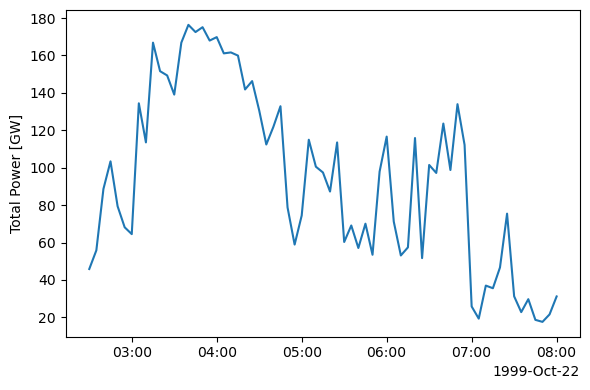

In [15]:
fig, ax = plt.subplots(figsize=(6,4))
ds_E['total_power'].plot(ax=ax)
plt.ylabel('Total Power [GW]')
plt.xlabel(' ')
plt.tight_layout()
#plt.savefig('ESN_Total_Power.png', dpi=300)

/tmp/ipykernel_23214/1835909795.py:7: UserWarning: The following kwargs were not used by contour: 'center'
  contour = axs.contourf(theta_rad, r, Ex, cmap='bwr', levels=100, extend='both', center=0)


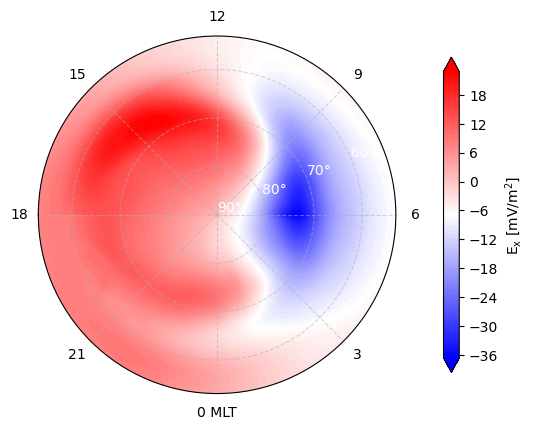

In [16]:
theta = np.linspace(0, 360, 79) +180
theta_rad = np.deg2rad(theta) 
r = 90 - np.linspace(53.1, 90, 29)
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5.5, 4.5))

Ex = ds_E['Ex'].mean(dim='dt').values / 1e-3
contour = axs.contourf(theta_rad, r, Ex, cmap='bwr', levels=100, extend='both', center=0)
#quiver = axs.quiver(theta_rad, r, ds_E['Ex'].mean(dim='dt').values, ds_E['Ey'].mean(dim='dt').values, scale=1, scale_units='inches', color='black')
Qj_label = r'E$_\mathrm{x}$ [mV/m$^2$]'
plt.colorbar(contour, ax=axs, label=f'{Qj_label}',pad=0.1,shrink=0.8)
#axs.set_ylim([0, 50])
axs.set_yticks([0, 10, 20, 30])
axs.set_yticklabels(["90°", "80°", "70°", "60°"], color='white')
axs.set_xlim([-np.pi, np.pi])
axs.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs.set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.savefig('electric_field_avg.png', dpi=300)

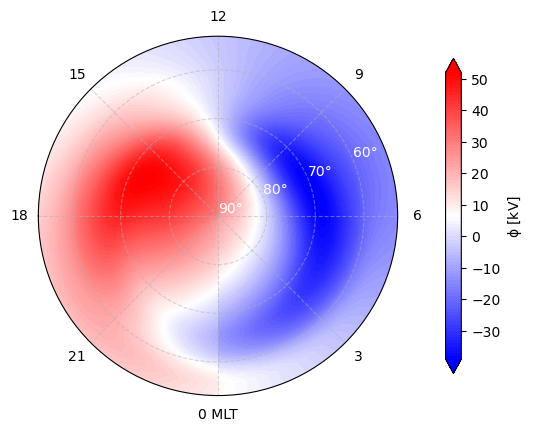

In [17]:
theta = np.linspace(0, 360, 79) - 90
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(53.1, 90, 29)
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5.5, 4.5))


Ex = ds_E['esn_pot'].mean(dim='dt').values
contour = axs.contourf(theta_rad, r, Ex, cmap='bwr', levels=100, extend='both')
Qj_label = r'$\mathrm{\phi}$ [kV]'
plt.colorbar(contour, ax=axs, label=f'{Qj_label}',pad=0.1,shrink=0.8)
#axs.set_ylim([0, 50])
axs.set_yticks([0, 10, 20, 30])
axs.set_yticklabels(["90°", "80°", "70°", "60°"], color='white')
axs.set_xlim([-np.pi, np.pi])
axs.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs.set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

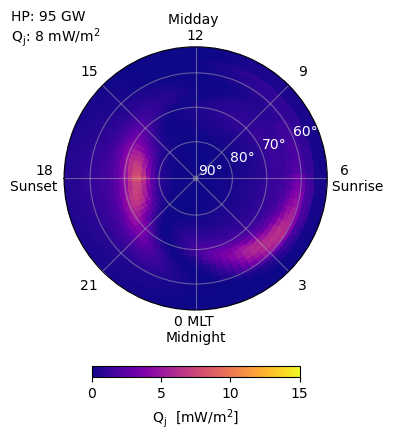

In [18]:
theta = np.linspace(0, 360, 79)
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(53.1, 90, 29)
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5.5, 4.5))

shrink = .28
pad = 0.18
t_pad = 10

Qjz = ds_E['Qjx'].mean('dt').values
Qjx = ds_E['Qjx'].mean('dt').values
total_power = ds_E['total_power'].mean('dt').values


#Qjz = ds_E['Qjx'].sel(dt='1999-10-22 05:00:00').values
#Qjx = ds_E['Qjx'].sel(dt='1999-10-22 05:00:00').values
Qj = Qjx + Qjz
Qj_mean = np.max(Qj)

#Ex = ds_E['Qjx'].mean(dim='dt').values
#contour = axs.contourf(theta_rad, r, Qj, cmap='plasma', levels=np.linspace(0,15,100), extend='both')
contour = axs.pcolormesh(theta_rad, r, Qj, cmap='plasma', vmin=0, vmax=15)
Qj_label = r'Q$_\mathrm{j}$'
#plt.colorbar(contour, ax=axs, label=f'{Qj_label}',pad=0.15,shrink=0.4, orientation='horizontal', ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
#plt.colorbar(contour, ax=axs, label=f'{Qj_label}',pad=0.15,shrink=0.4, orientation='horizontal', ticks=[0, 2, 4, 6, 8, 10])
plt.colorbar(contour, ax=axs, label=f'{Qj_label}  [mW/m$^2$]',pad=0.15,shrink=0.4, orientation='horizontal', ticks=[0, 5, 10, 15])
#axs.set_ylim([0, 34])

#add total pwoer as text to top left of plot
#plt.annotate(f'{total_power:.2f} GW', xy=(10, 10), xytext=(t_pad, -t_pad), textcoords='offset points', color='black')
#plt.title(f'{total_power:.0f} GW', pad=10, loc='center', color='black')
#title but right aligned not center
#axs.set_title(f'{total_power:.2f} GW', loc='right', pad=10)
axs.annotate(f'HP: {total_power:.0f} GW', xy=(-0.2, 1.1), xycoords='axes fraction',fontsize=10)
axs.annotate(f'{Qj_label}: {Qj_mean:.0f} mW/m$^2$', xy=(-0.2, 1.02), xycoords='axes fraction',fontsize=10)

axs.set_yticks([0, 10, 20, 30])
axs.set_yticklabels(["90°", "80°", "70°", "60°"], color='white')
axs.set_xlim([-np.pi, np.pi])
axs.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
plt.grid(True, linestyle='-', alpha=0.5)
plt.tight_layout()
#plt.savefig('joule_heating_avg.png', dpi=300)

In [19]:
def plot_map(ds):
    for dt in ds['dt'].values:
        ds_dt = ds.sel(dt=dt)
        dt_lab = pd.to_datetime(dt).strftime('%Y-%m-%d %H:%M:%S')

        theta = np.linspace(0, 360, 79)
        theta_rad = np.deg2rad(theta)
        r = 90 - np.linspace(53.1, 90, 29)
        fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5.5, 4.5))

        Qjx = ds_dt['Qjx'].values
        Qjy = ds_dt['Qjy'].values

        Qj = Qjx + Qjz
        #Qj = np.log10(Qj)
        Qj_mean = np.max(Qj)
        total_power = ds_dt['total_power'].values

        contour = axs.pcolormesh(theta_rad, r, Qj, cmap='hot', vmin=0, vmax=12)
        Qj_label = r'Q$_\mathrm{j}$'
        #lt.colorbar(contour, ax=axs, label=f'{Qj_label}',pad=0.15,shrink=0.4, orientation='horizontal', ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.colorbar(contour, ax=axs, label=f'{Qj_label} [mW/m$^2$]',pad=0.15,shrink=0.4, orientation='horizontal', ticks=[0, 2, 4, 6, 8,10,12], extend='both')
        #plt.colorbar(contour, ax=axs, label=f'{Qj_label}  [mW/m$^2$]',pad=0.15,shrink=0.4, orientation='horizontal', ticks=[0, 5, 10, 15])
        #axs.set_ylim([0, 34])

        #add total pwoer as text to top left of plot
        #plt.annotate(f'{total_power:.2f} GW', xy=(10, 10), xytext=(t_pad, -t_pad), textcoords='offset points', color='black')
        #plt.title(f'{total_power:.0f} GW', pad=10, loc='center', color='black')
        #title but right aligned not center
        axs.set_title(f'{dt_lab}', loc='center', pad=15, fontsize=11)
        axs.annotate(f'HP: {total_power:.0f} GW', xy=(-0.2, 1.1), xycoords='axes fraction',fontsize=10)
        axs.annotate(f'{Qj_label}: {Qj_mean:.1f} mW/m$^2$', xy=(-0.2, 1.02), xycoords='axes fraction',fontsize=10)

        axs.set_yticks([0, 10, 20, 30])
        axs.set_yticklabels(["90°", "80°", "70°", "60°"], color='white')
        axs.set_xlim([-np.pi, np.pi])
        axs.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
        axs.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
        plt.grid(True, linestyle='-', alpha=0.5)
        #plt.tight_layout()

        plt.tight_layout()
        plt.savefig(f'/home/sachin/Documents/NIPR/Research/Analysis/Aug-24/plots/Joule Heating/1999-10-22/{dt_lab}.png', dpi=400, bbox_inches='tight')
        plt.close()
        #break

plot_map(ds_E)